# <span style="color:#0b486b">SIT112 - Data Science Concepts - Assignment 2</span>
---
Lecturer: Shalini Stephen | shalini.stephen@deakin.edu.au<br />

## Deakin College  
##### Associated with Deakin University, VIC 3215, Australia

### <span style="color:#0b486b">Due: Week 10 Saturday, 15th January 2022, by 10:00 pm </span>
---

## <span style="color:#0b486b">Part 1: Crawling and Storing Tweet Data</span>


The first part of the assignment examines your skills and knowledge to query tweets and store them in json files. For **each** provided keyword, your tasks are:

* Crawl all tweets which contain this keyword written in English and geocoded within the location, provided for your group.
* Store the tweets collected into json files.

***Follow the instructions below to complete your task***.

In [173]:
import re
import json
import xml
import numpy as np
from collections import Counter
from TwitterAPI import TwitterAPI 
from sklearn.cluster import KMeans

import requests
requests.packages.urllib3.disable_warnings()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

**Instruction 1.1**. Enter your provided keywords to the variable **keywords** below.

[**Total mark: 1**]

In [174]:
keywords =  ["grape", "design", "expert"] 

**Instruction 1.2**. Before you can perform a query to Twitter API, you need to supply authentication information. Practical sessions 6 and 7 show you how to obtain this information. **Your task is to supply the authentication information in the cell below**.

**Note**: You might decide to regenerate this authentication from the pracs if you would like too. <span style="color:red">After the assignment has been marked, you are strongly recommended to regenerate this authentication information from your account to maintain your privacy.</span> 
Please create one Twitter API developer account per group and use one set of Twitter API credentials for the group.

[**Total mark: 3**]

In [175]:
CONSUMER_KEY = "HLnOFAqRgkrJaaqMoy41a0nxj"
CONSUMER_SECRET = "tz4GKwFn9dsqYv6Mnl9mzctSqV5LeOVGhAuvr1KW0c2LpLuprZ"
OAUTH_TOKEN = "763929928219766784-AjLCTTzhDWx87EJxHpfeC7IPvFnQB1t"
OAUTH_TOKEN_SECRET = "MTJThLdK6SkVzqnHEGvja2yUhIDSCZ8XCfNzjDTUgiXAu"

api = TwitterAPI(CONSUMER_KEY,
                 CONSUMER_SECRET,
                 OAUTH_TOKEN,
                 OAUTH_TOKEN_SECRET)

**Note**: As you have learned from the pracical sessions, to perform a query from Twitter API for a particular geo-coded location you need a center point and a radius. The center point is specified by its (latitude,longitute) pair. **The information below has been provided to you to perform the query in the subsequent tasks**.

In [176]:
PLACE_LAT = 33.4484
PLACE_LON = -112.074
PLACE_RAD = 100

**Instruction 1.3**. For each keyword, you are required to crawl at least **120** tweets (the more the better) using the Twitter API. However, as you have learned from the practical sessions, each query will return a maximum of only **100** tweets. Therefore, subsequent query **must** use the maximum Tweet ID from the previous batch to crawl the next lot.

The following function, called ***retrieve_tweets()***, has been **partially** implemented to automatically download tweets until it reaches the maximum number of tweets needed. 

For example, a function call
```
retrieve_tweets(api, 'car', 50, 200, latitude, longitude, radius)
```
will attempt to crawl a total of at least 120 tweets that contains the word 'car' for a location with given latitude, longidude and radius around it. Within each single query, it will attempt to obtain 50 tweets.

**Your task is to walk through this function and enter your own codes where instructed to complete the function**.

[**Total mark: 5**]

In [5]:
def retrieve_tweets(api, keyword, batch_count, total_count, latitude, longitude, radius):
    tweets_unfiltered = []
    tweets = []
    
    batch_count = str(batch_count)
    
    resp = api.request('search/tweets', {'q':keyword,
                                         'count':batch_count,
                                         'lang':'en',
                                         'result_type':'recent',
                                         'geocode':'{},{},{}mi'.format(latitude, longitude, radius)})
    
    if ('errors' in resp.json()):
        errors = resp.json()['errors']
        if (errors[0]['code'] == 88):
            print('Too many attempts to load tweets.')
            print('You need to wait for a few minutes before accessing Twitter API again.')
    
    if ('statuses' in resp.json()):
        tweets_unfiltered += resp.json()['statuses']
        tweets = [tweet for tweet in tweets_unfiltered if ((tweet['retweeted'] != True) and ('RT @' not in tweet['text']))]
    
        ids = [tweet['id'] for tweet in tweets_unfiltered]
        max_id_str = str(max(ids))

        number_of_tweets = len(tweets)
        while number_of_tweets < total_count:

            resp = api.request('search/tweets', {'q':keyword,
                                             'count':batch_count,
                                             'lang':'en',
                                             'result_type':'recent',
                                             'max_id':max_id_str,
                                             'geocode':'{},{},{}mi'.format(latitude, longitude, radius)}
                          )

            if ('statuses' in resp.json()):
                tweets_unfiltered += resp.json()['statuses']
                tweets = [tweet for tweet in tweets_unfiltered if ((tweet['retweeted'] != True) and ('RT @' not in tweet['text']))]
 
                ids = [tweet['id'] for tweet in tweets_unfiltered]
                max_id_str = str(max(ids))
            
                number_of_tweets = len(tweets)
        
            print("{} tweets are collected for keyword {}. Last tweet created at {}".format(number_of_tweets, 
                                                                                    keyword, 
                                                                                    tweets[number_of_tweets-1]['created_at']))
    return tweets

**Instruction 1.4**. After having defined the ***retrieve_tweets()*** function above, you are now ready to use this function to collect your tweets. Your task is to write the code to perform three function calls, each of which corresponds to one keyword. And, you are required to collect at least **200** tweets for each keyword (the more the better).

[**Total mark: 5**]

In [90]:
batch = 75
total = 150

k1_tweets = retrieve_tweets(api, keywords[0], batch, total, PLACE_LAT, PLACE_LON, PLACE_RAD)
k2_tweets = retrieve_tweets(api, keywords[1], batch, total, PLACE_LAT, PLACE_LON, PLACE_RAD)
k3_tweets = retrieve_tweets(api, keywords[2], batch, total, PLACE_LAT, PLACE_LON, PLACE_RAD)

76 tweets are collected for keyword grape. Last tweet created at Sat Dec 04 10:38:34 +0000 2021
114 tweets are collected for keyword grape. Last tweet created at Sat Dec 04 10:38:34 +0000 2021
152 tweets are collected for keyword grape. Last tweet created at Sat Dec 04 10:38:34 +0000 2021
150 tweets are collected for keyword design. Last tweet created at Sun Dec 12 12:06:24 +0000 2021
150 tweets are collected for keyword expert. Last tweet created at Fri Dec 10 20:06:12 +0000 2021


**Instruction 1.5**. To verify the downloading process, write your code to print out the number of tweets which has been collected for each keyword.

[**Total mark: 2**]

In [91]:
print(f"Number of tweets collected for keyword 1 ({keywords[0]}): {len(k1_tweets)}")
print(f"Number of tweets collected for keyword 2 ({keywords[1]}): {len(k2_tweets)}")
print(f"Number of tweets collected for keyword 3 ({keywords[2]}): {len(k3_tweets)}")

Number of tweets collected for keyword 1 (grape): 152
Number of tweets collected for keyword 2 (design): 150
Number of tweets collected for keyword 3 (expert): 150


**Note:** Each tweet is stored in a dictionary where its keywords are fields in the tweet and values are the information of the fields. The cell below print the type of a tweet.

In [92]:
print(type(k1_tweets[0]))

<class 'dict'>


**Instruction 1.6**.  To examine what the tweets look like, in the cell below write your code to print out all fields of the first tweet in `k1_tweets` and print out the text of the first tweet collected for each keyword.

[**Total mark: 4**]

In [93]:
print('Fields of the first tweet:\n\n', k1_tweets[0].keys())

print("\nThe text of the first tweet for \"{}\":\n".format(keywords[0]))
print(k1_tweets[0]['text'])

print("\nThe text of the first tweet for \"{}\":\n".format(keywords[1]))
print(k2_tweets[0]['text'])

print('\nThe text of the first tweet for \"{}\":\n'.format(keywords[2]))
print(k3_tweets[0]['text'])

Fields of the first tweet:

 dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

The text of the first tweet for "grape":

I decided to try pb &amp; grapes and ended up discovering grape fieri https://t.co/9ANI7FV5QJ https://t.co/3D7Zz0gvRG

The text of the first tweet for "design":

#EKB #Followback RT: the_alice_pp RT myhouseidea: Banjo design by littlebyronco
Get Inspired, visit… https://t.co/ixificLLPq

The text of the first tweet for "expert":

#Tucsonseoservicesfirm is a Tucson SEO expert helping small business clients from all walks of life with affordable… https

**Note**. When collecting data from the Internet, such as Twitter, it is important that we store the data collected in an appropriate format for later data analysis task. We have learned that json is a poplular lightweight data format that can be handy to store unstructured data. For example, with NoSQL we can directly query these files in a 'scaling out' fashion. These technologies are representative features of Big Data Analytics.

The following function has been designed for you to save an object which is a list of dictionaries (such as k1_tweets variable) to a json file. **You will need this function for your next task**.

In [94]:
def save_to_json(obj, filename):
    with open(filename, 'w') as fp:
        json.dump(obj, fp, indent=4, sort_keys=True)   

**Instruction 1.7**. Use the function ***save_to_json()*** defined above, for each collection of tweets you have crawled for each keyword, save them into a file named **w.json** where **w** is the keyword.

For example, if your keywords are 'w1', 'w2' and 'w3', then your code must generate three file w1.json, w2.json and w3.json. **Important: you must submit these files together with your notebook solution**.

[**Total mark: 5**]

In [95]:
save_to_json(k1_tweets, keywords[0]+'.json')
save_to_json(k2_tweets, keywords[1]+'.json')
save_to_json(k3_tweets, keywords[2]+'.json')

###                                     END OF PART 1
----

## Part 2: Data Analytics

### NOTE: ONCE YOU LOADED THE TWEETS AND SAVED JSONS, YOU DO NOT NEED TO REDOWNLOAD THE TWEETS. YOU CAN LOAD THEM FROM JSONS IN THE FOLLOWING SECTION.

The second part of this assignment will examine your skills and knowlege in data manipulation and analysis tasks. It includes three main components:

**Part 2A**. For each keyword, you will be required to load the tweets from your saved json files (from Part 1) and filter out all tweets that are too short.

**Part 2B**. Using your knowledge from practical sessions 5, 6 and 7, you will be required to construct the term-by-document matrix for the tweets and to perform visualisation tasks to understand them.

**Part 2C**. You will apply the Kmeans clustering algorithm to cluster your tweets and report the clustering results.

***Follow the instructions below to complete your assigned tasks***.

### Part 2A: Load and Filter Tweets from Files

**Instruction 2.1**. The following function, named ***read_json_file()***, has been partially implemented to load data from a json file. This function will be used later on to load three json files you have saved from Part 1. Your task is to insert your own code where instructed to complete this function.

[**Total mark: 3**]

In [177]:
def read_json_file(filename):
    with open(filename, 'r') as fp:
        content = fp.read()
        
    data = json.loads(content)
    return data     

**Instruction 2.2**. Now use the ***read_json_file()*** function defined above, write three function calls to load data from three json files you have saved from Part 1.

[**Total mark: 4**]

In [178]:
k1_tweets = read_json_file(keywords[0]+'.json')
k2_tweets = read_json_file(keywords[1]+'.json')
k3_tweets = read_json_file(keywords[2]+'.json')

**Instruction 2.3**. To examine the number of tweets loaded from your data files, write your code to print out the number of tweets contained in three variables: ***k1_tweets, k2_tweets*** and ***k3_tweets***.

[**Total mark: 2**]

In [179]:
print(f'Number of tweets in k1_tweets: {len(k1_tweets)}')
print(f'Number of tweets in k2_tweets: {len(k2_tweets)}')
print(f'Number of tweets in k3_tweets: {len(k3_tweets)}')

Number of tweets in k1_tweets: 152
Number of tweets in k2_tweets: 150
Number of tweets in k3_tweets: 150


**Note**. When analysing tweets and text documents in general, an important analytics skill is to pre-process and filter the data into the form that one can start to apply analytics methods to extract knowledge. 

Tweets that are too short might not be useful for analysis. We define that tweets having less than 50 characters are short and should be remove. 

**Instruction 2.4**. In this task, you need to filter all short tweets.

1. Write a function called `is_short_tweet` that takes a tweet as an input and return True if the text of the tweet has less than 50 characters and False otherwise. **(5 marks)**

2. Write your codes to remove all tweets that have less than 50 characters in variables ***k1_tweets***, ***k2_tweets*** and ***k3_tweets*** and store the results in the new variables ***k1_tweets_filtered***, ***k2_tweets_filtered*** and ***k3_tweets_filtered***, respectively. **(5 marks)**

[**Total mark: 10**]

In [180]:
def is_short_tweet(tweet):  
    result = len(tweet['text']) < 50
    return result

In [181]:
k1_tweets_filtered = [tweet for tweet in k1_tweets if not(is_short_tweet(tweet))]
k2_tweets_filtered = [tweet for tweet in k2_tweets if not(is_short_tweet(tweet))]
k3_tweets_filtered = [tweet for tweet in k3_tweets if not(is_short_tweet(tweet))]


print(len(k1_tweets), len(k1_tweets_filtered))
print(len(k2_tweets), len(k2_tweets_filtered))
print(len(k3_tweets), len(k3_tweets_filtered))

152 140
150 138
150 146


**Instruction 2.5**. For each keyword, print out the number of tweets that have been removed.

[**Total mark: 2**]

In [182]:
k1_diff = len(k1_tweets) - len(k1_tweets_filtered)
k2_diff = len(k2_tweets) - len(k2_tweets_filtered) 
k3_diff = len(k3_tweets) - len(k3_tweets_filtered)

print(f"Number of tweets removed for keyword 1 ('{keywords[0]}'): {k1_diff}")
print(f"Number of tweets removed for keyword 2 ('{keywords[1]}'): {k2_diff}")
print(f"Number of tweets removed for keyword 3 ('{keywords[2]}'): {k3_diff}")

Number of tweets removed for keyword 1 ('grape'): 12
Number of tweets removed for keyword 2 ('design'): 12
Number of tweets removed for keyword 3 ('expert'): 4


**Instruction 2.6**. To examine what the tweets look like after being loaded from the data files and filtered, in the cell below write your code to print out the last **5** tweets for each keyword. 

You **must** use the variables ***k1_tweets_filtered, k2_tweets_filtered*** and ***k3_tweets_filtered*** which have stored the data after the filtering process for this task.

[**Total mark: 4**]

In [183]:
def print_filtweets(last_five):
    for i, tweet in enumerate(last_five):
        print(f'Tweet: {i+1}')
        print(tweet['text'], '\n')

        
print('The last 5 tweets for \"{}\":\n'.format(keywords[0]))
print_filtweets(k1_tweets_filtered[-5:])


print('\nThe last 5 tweets for \"{}\":\n'.format(keywords[1]))
print_filtweets(k2_tweets_filtered[-5:])


print('\nThe last 5 tweets for \"{}\":\n'.format(keywords[2]))
print_filtweets(k3_tweets_filtered[-5:])

The last 5 tweets for "grape":

Tweet: 1
@lounge_dawg @chadmask_msu My standards are higher than “red grape wine.” 

Tweet: 2
@Cirus_thy_Grape So easily refuted. https://t.co/PrWMB9xkCC 

Tweet: 3
Y’all was out here putting grape koolaid on chicken for ya lil tik tok laughs and boom! 3 piece cost $18.. DH.. 

Tweet: 4
@annieblue94 @Cirus_thy_Grape ...

I think his point is that Jesus loves rapist pedophiles and true monsters too. 

Tweet: 5
@Cirus_thy_Grape Hey, Jesu

You're running thick on the irony today. 


The last 5 tweets for "design":

Tweet: 1
The design of this #uniquehome makes it easy to see the inside. #coolhomes  https://t.co/uE9jEL1AP7 https://t.co/aYa82GPlV6 

Tweet: 2
Another new design on @redbubble

Peace 21

Over 60 years ago, the peace symbol was born. Today, we need it more th… https://t.co/xbx4hCUyLh 

Tweet: 3
@Seancarter7878 @BebopPrime @essex7927 @yaoibunga @MennoTheMiner @Liv_Agar I like to think of it as the small turns… https://t.co/Y393R3trEL 

Tweet: 4
Cu

### Part 2B: Constructing Term-by-Document Matrix

As we have learned in our class, in text analytics and in general dealing with unstructured data, to start perform **computational** tasks such as computing the distance between two documents, we need to represent them in **numerical** formats. A popular technique we have learned is the bag-of-word representation and the term-by-document matrix, also known as the vector-space model.

This part of the assignment will require you to construct the term-by-document matrix for the tweets stored in three variables ***k1_tweets_filtered***, ***k2_tweets_filtered*** and ***k3_tweets_filtered***.

**Note.** Tweets are often not neat as you might have seen from early tasks. As tweet such as this 
```
Happy shopping👗👚👠👜 (with Vivi and Irmalia at @infomog) — https://t.co/fUGO9Eex1r
```
might contain non-ASCII characters, emoticon, punctuations, etc. Building a bag-of-word representation **without** pre-processing the data can be ineffective. 

The following function ***pre_process()*** has been designed to preprocess the data for you.

In [184]:
def remove_non_ascii(s): return "".join(i for i in s if ord(i)<128)
def pre_process(doc):
    """
    pre-processes a doc
      * Converts the tweet into lower case,
      * removes the URLs,
      * removes the punctuations
      * tokenizes the tweet
      * removes words less that 3 characters
    """
    
    doc = doc.lower()
    # getting rid of non ascii codes
    doc = remove_non_ascii(doc)
    
    # replacing URLs
    url_pattern = "http://[^\s]+|https://[^\s]+|www.[^\s]+|[^\s]+\.com|bit.ly/[^\s]+"
    doc = re.sub(url_pattern, 'url', doc) 

    # removing dollars and usernames and other unnecessary stuff
    userdoll_pattern = "\$[^\s]+|\@[^\s]+|\&[^\s]+|\*[^\s]+|[0-9][^\s]+|\~[^\s]+"
    doc = re.sub(userdoll_pattern, '', doc)
    
    
    # removing punctuation
    punctuation = r"\(|\)|#|\'|\"|-|:|\\|\/|!|\?|_|,|=|;|>|<|\.|\@"
    doc = re.sub(punctuation, ' ', doc)
    
    return [w for w in doc.split() if len(w) > 2]

**Note**. For example, the following code will display the first tweet stored in the variable ***k1_tweets_filtered*** (for the first keyword) before and after it has been pre-processed.

In [185]:
tweet_k1 = k1_tweets_filtered[0]['text']
tweet_k1_processed = pre_process(tweet_k1)

print(tweet_k1)
print(' '.join(tweet_k1_processed))

I decided to try pb &amp; grapes and ended up discovering grape fieri https://t.co/9ANI7FV5QJ https://t.co/3D7Zz0gvRG
decided try grapes and ended discovering grape fieri url url


**Instruction 2.7**. Use the example above, write your code to display the **first** tweets stored in the variables ***k2_tweets_filtered*** and ***k2_tweets_filtered*** before and after they have been pre-processed using the function ***pre_process()*** supplied earlier.

[**Total mark: 1**]

In [186]:
tweet_k2 = k2_tweets_filtered[0]['text']
tweet_k2_processed = pre_process(tweet_k2)

print(f"First tweet of keyword 2 ('{keywords[1]}'):")
print(f'Before: {tweet_k2}')
print(f"After: {' '.join(tweet_k2_processed)}")

tweet_k3 = k3_tweets_filtered[0]['text']
tweet_k3_processed = pre_process(tweet_k3)

print(f"\nFirst tweet of keyword 3 ('{keywords[2]}'):")
print(f'Before: {tweet_k3}')
print(f"After: {' '.join(tweet_k3_processed)}")

First tweet of keyword 2 ('design'):
Before: #EKB #Followback RT: the_alice_pp RT myhouseidea: Banjo design by littlebyronco
Get Inspired, visit… https://t.co/ixificLLPq
After: ekb followback the alice myhouseidea banjo design littlebyronco get inspired visit url

First tweet of keyword 3 ('expert'):
Before: #Tucsonseoservicesfirm is a Tucson SEO expert helping small business clients from all walks of life with affordable… https://t.co/7JgYgJcQjm
After: tucsonseoservicesfirm tucson seo expert helping small business clients from all walks life with affordable url


**Instruction 2.8**. Write your code to pre-process and clean up all tweets stored in the variable ***k1_tweets_filtered***, ***k2_tweets_filtered*** and ***k3_tweets_filtered*** using the function ***pre_process()*** to result in new variables ***k1_tweets_processed***, ***k2_tweets_processed*** and ***k3_tweets_processed***.

[**Total mark: 2**]

In [187]:
k1_tweets_processed = [pre_process(tweet['text']) for tweet in k1_tweets_filtered]
k2_tweets_processed = [pre_process(tweet['text']) for tweet in k2_tweets_filtered]
k3_tweets_processed = [pre_process(tweet['text']) for tweet in k3_tweets_filtered]

**Instruction 2.9**. Now, write your code to print out the **last 5 processed tweets** for each keyword *(the processed tweets are stored in **k1_tweets_processed**, **k2_tweets_processed** and **k3_tweets_processed**)*

[**Total mark: 2**]

In [188]:
# YOU ARE REQUIRED TO INSERT YOUR CODE IN THIS CELL
'''
Now write your code to print out the last 5 processed tweets for each keyword.
Hint: Each tweet in tweets_processed is now a list of words, not a string. 
      To print a string, you might need to use ' '.join(tweet), 
      when tweet is a processed tweet

'''

def print_protweets(last_five):
    for i, tweet in enumerate(last_five):
        print(f'Tweet: {i+1}')
        print(' '.join(tweet), '\n')
    

print('The last 5 processed tweets for k1_tweets_processed:\n')
print_protweets(k1_tweets_processed[-5:])
   
print('\nThe last 5 processed tweets for k2_tweets_processed:\n')
print_protweets(k2_tweets_processed[-5:])
   
print('\nThe last 5 processed tweets for k3_tweets_processed:\n')
print_protweets(k3_tweets_processed[-5:])

The last 5 processed tweets for k1_tweets_processed:

Tweet: 1
standards are higher than red grape wine 

Tweet: 2
easily refuted url 

Tweet: 3
yall was out here putting grape koolaid chicken for lil tik tok laughs and boom piece cost 

Tweet: 4
think his point that jesus loves rapist pedophiles and true monsters too 

Tweet: 5
hey jesu you running thick the irony today 


The last 5 processed tweets for k2_tweets_processed:

Tweet: 1
the design this uniquehome makes easy see the inside coolhomes url url 

Tweet: 2
another new design peace over years ago the peace symbol was born today need more url 

Tweet: 3
like think the small turns url 

Tweet: 4
custom made coffee tables choose your own design whatsapp djsbu umjolowithazola url 

Tweet: 5
have this starbitt design can offer url 


The last 5 processed tweets for k3_tweets_processed:

Tweet: 1
local expert and professional negotiator proud your real estate agent and trusted advocate url 

Tweet: 2
hear what sleep pros recommend o

**Note**. The following function ***construct_termdoc()*** has been implemented to construct the term-by-document matrix from a corpus of text data. **You will need this function for subsequent task**.

In [189]:
def construct_termdoc(docs, vocab=[]):
    # vocab is not passed
    if vocab == []:
        vocab = set()
        termdoc_sparse = []

        for doc in docs:       
            # computes the frequencies of doc
            doc_sparse = Counter(doc)    
            termdoc_sparse.append(doc_sparse)
            
            # update the vocab
            vocab.update(doc_sparse.keys())  

        vocab = list(vocab)
        vocab.sort()
    
    else:
        termdoc_sparse = []        
        for doc in docs:
            termdoc_sparse.append(Counter(doc))
            

    n_docs = len(docs)
    n_vocab = len(vocab)
    termdoc_dense = np.zeros((n_docs, n_vocab), dtype=int)

    for j, doc_sparse in enumerate(termdoc_sparse):
        for term, freq in doc_sparse.items():
            try:
                termdoc_dense[j, vocab.index(term)] = freq
            except:
                pass
            
    return termdoc_dense, vocab

**Instruction 2.10 (D)**. In the function ***construct_termdoc()***, a function **set** is used. Learn what this function does and explain its role in the function ***construct_termdoc()***. Write a brief answer.

[**Total mark: 2**]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
worse would wouldve yall you


Text(0.5, 1.0, 'Term-by-Document matrix from tweets collected for keyword "grape"')

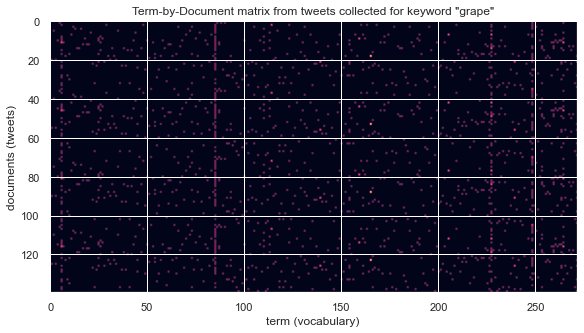

In [191]:
k1_termdoc, k1_vocab = construct_termdoc(k1_tweets_processed)

# print out the term-by-document matrix
print(k1_termdoc)
# print out the first 5 vocabulary entries
print(' '.join(k1_vocab[-5:]))  # print out only the first 5 vocabulary entries

# visualise the term-by-document matrix
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(k1_termdoc)
ax.set_xlabel('term (vocabulary)')
ax.set_ylabel('documents (tweets)')
ax.set_title('Term-by-Document matrix from tweets collected for keyword \"{}\"'.format(keywords[0]))

**Note**. Next, we would like to compute the pairwise distances between every two tweets. This will help us to see how similar tweets are. This is a computational task that would be *not* possible to do if we use the raw tweets.

However, with the term-by-document matrix, each tweet now is vector and corresponds to a row in the term-by-document matrix. Hence, we can use the distance between vectors to compute the distance between tweets. This is also known as the **vector space model** in information retrieval literature.

**Instruction 2.11**. Your tasks are:

1. Define a function to compute and return the Euclidean distance between two vectors as we have learned from the class notes. **(2 marks)**

2. Define a function to compute and return the cosine distance between two vectors as we have learned from the class notes. **(2 marks)**

3. Construct a single function that returns two distance matrices ***euclidean_distance_matrix***, and ***cosine_distance_matrix***, whose elements (i,j) store the Eulidean distance and the cosine distance between tweets i-th and i-jth. **You will need this function for subsequent task**. **(2 marks)**

**[Total mark: 6]**

In [192]:
# YOU ARE REQUIRED TO INSERT YOUR CODE IN THIS CELL

def Euclidean_distance(x,y):
    try:
        d = (x - y) ** 2
        return np.sqrt(d.sum())
    except ValueError as e:
        print('Vectors are not the same size. Computation not possible.')
        return None

In [193]:
# YOU ARE REQUIRED TO INSERT YOUR CODE IN THIS CELL
def cosine_distance(x,y):
    try:
        num = (x * y).sum()
        den = np.sqrt((x * x).sum()) * np.sqrt((y * y).sum())
        s = num.astype(float)/den
        return 1.0 - s
    except ValueError as e:
        print('Vectors are not the same size. Computation not possible.')
        return None

In [194]:
def compute_distance_matrices(termdoc):
    # INSERT YOUR CODE HERE

    n_rows = termdoc.shape[0]
    euclidean_distance_matrix = np.zeros((n_rows, n_rows))
    cosine_distance_matrix = np.zeros((n_rows, n_rows))
    
    for i in range(n_rows):
        for j in range(n_rows):
            euclidean_distance_matrix[i, j] = Euclidean_distance(termdoc[i, :], termdoc[j, :])
            cosine_distance_matrix[i, j] = cosine_distance(termdoc[i, :], termdoc[j, :])
    
    return euclidean_distance_matrix, cosine_distance_matrix

**Instruction 2.12**. 

1. Now you need to compute the distance matrices for **k1_termdoc** and then visualise these distance matrices. **(2 marks)**

2. Explain why cosine distance is always in the range between 0 and 1. **(2 marks)**

3. (HD) Using a scatter plot demonstrate relationship between Euclidean distance and cosine distance. **(2 marks)**

4. (HD) Explain why cosine similarity increases if Euclidean distance decreases. **(2 marks)**


**[Total mark: 8]**

Text(0.5, 1.0, 'K1 Cosine Distances')

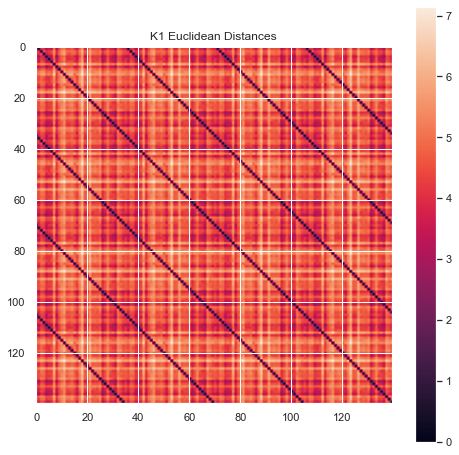

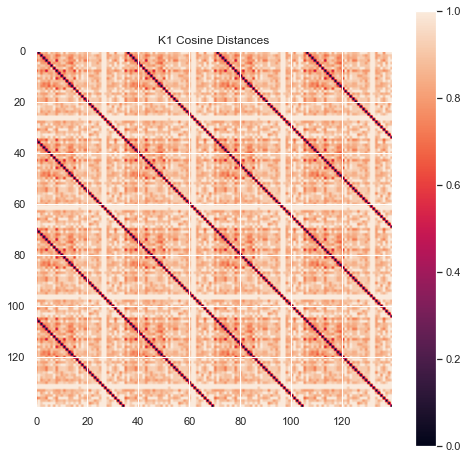

In [195]:
k1_euclidean_distances, k1_cosine_distances = compute_distance_matrices(k1_termdoc)

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(k1_euclidean_distances)
cbar = fig.colorbar(cax)
ax.set_title('K1 Euclidean Distances')

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(k1_cosine_distances)
cbar = fig.colorbar(cax)
ax.set_title('K1 Cosine Distances')

Text(0, 0.5, 'Cosine distance')

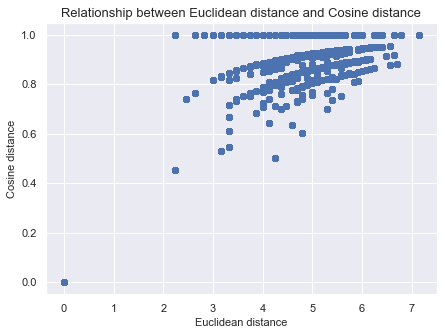

In [197]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(k1_euclidean_distances, k1_cosine_distances)
ax.set_title("Relationship between Euclidean distance and Cosine distance", fontsize=13)
ax.set_xlabel("Euclidean distance", fontsize=11)
ax.set_ylabel("Cosine distance", fontsize=11)

**Instruction 2.13**. Similar to the example above for the first keyword, your task is to write codes in the cell below to compute the term-by-document matrix and the vocabulary for tweets stored in ***k2_tweets_processed***, print out the last **5** vocabularies and visualise this term-by-document matrix.

[**Total mark: 2**]

Last 5 vocab words for keyword 2: years you your yours youve


Text(0.5, 1.0, 'Term-by-Document matrix from tweets collected for keyword "design"')

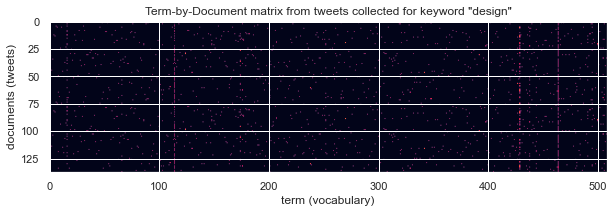

In [199]:
k2_termdoc, k2_vocab = construct_termdoc(k2_tweets_processed)

print('Last 5 vocab words for keyword 2:', ' '.join(k2_vocab[-5:]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(k2_termdoc)
ax.set_xlabel('term (vocabulary)')
ax.set_ylabel('documents (tweets)')
ax.set_title('Term-by-Document matrix from tweets collected for keyword \"{}\"'.format(keywords[1]))

***Instruction 2.14***. Next, your task is to write codes in the cell below to calculate the pairwise distance matrix for tweets collected for **second** keyword. Store this distance matrix in the variable named ***k2_euclidean_distances*** and **visualise** this matrix.

[**Total mark: 2**]

Text(0.5, 1.0, 'K2 Cosine Distances')

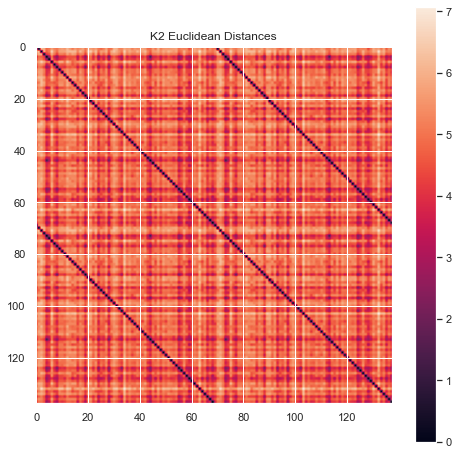

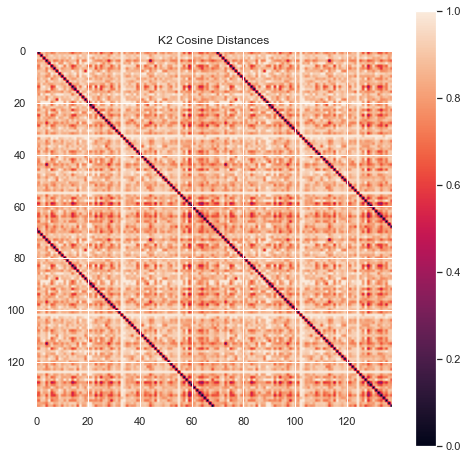

In [200]:
k2_euclidean_distances, k2_cosine_distances = compute_distance_matrices(k2_termdoc)

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(k2_euclidean_distances)
cbar = fig.colorbar(cax)
ax.set_title('K2 Euclidean Distances')

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(k2_cosine_distances)
cbar = fig.colorbar(cax)
ax.set_title('K2 Cosine Distances')

**Instruction 2.15**. Similarly, your task is to write codes in the cell below to compute the term-by-document matrix and the vocabulary for tweets stored in ***k3_tweets_processed***, print out the last **5** vocabularies and visualise this term-by-document matrix.

[**Total mark: 2**]

Last 5 vocab words for keyword 3: you youll your youre zimmerman


Text(0.5, 1.0, 'Term-by-Document matrix from tweets collected for keyword "expert"')

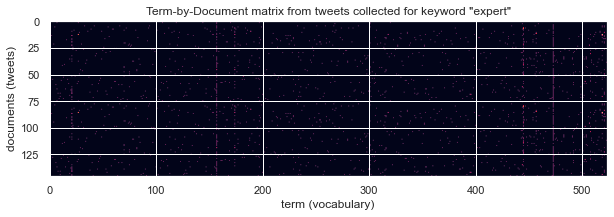

In [201]:
k3_termdoc, k3_vocab = construct_termdoc(k3_tweets_processed)

print('Last 5 vocab words for keyword 3:', ' '.join(k3_vocab[-5:]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(k3_termdoc)
ax.set_xlabel('term (vocabulary)')
ax.set_ylabel('documents (tweets)')
ax.set_title('Term-by-Document matrix from tweets collected for keyword \"{}\"'.format(keywords[2]))

***Instruction 2.16***. Next, your task is to write codes in the cell below to calculate the pairwise distance matrix for tweets collected for **third** keyword. Store this distance matrix in the variable named ***k3_euclidean_distances*** and visualise this matrix.

[**Total mark: 1**]

Text(0.5, 1.0, 'K3 Cosine Distances')

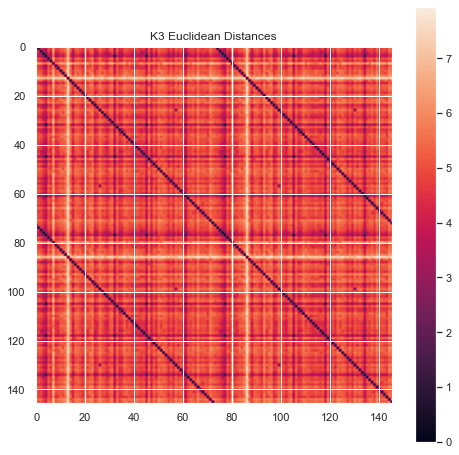

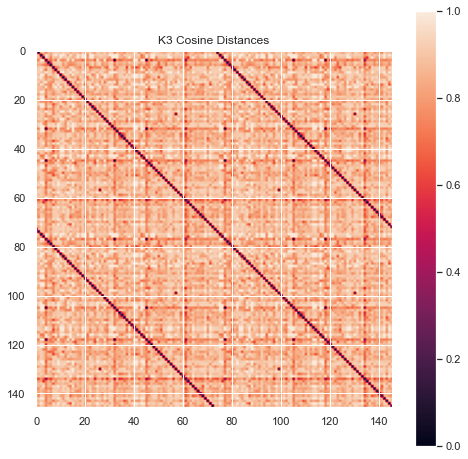

In [202]:
k3_euclidean_distances, k3_cosine_distances = compute_distance_matrices(k3_termdoc)

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(k3_euclidean_distances)
cbar = fig.colorbar(cax)
ax.set_title('K3 Euclidean Distances')

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(k3_cosine_distances)
cbar = fig.colorbar(cax)
ax.set_title('K3 Cosine Distances')

***Instruction 2.17 (HD)***. Compare the ranges of the values for cosine and Euclidean distances. Explain why the ranges are different. Think about the best example to explain why cosine distance is more convenient than Euclidean distance for text analysis.

[**Total mark: 2**]

### Part 2C: Data Clustering

Thus far in this assignment, we have collected tweets for each keyword and analysed them seperately. We have constructed the term-by-document matrix for each collection of tweets seperately. A fundemantal and common task in data science, analytics, machine learning, science and engineering is **clustering**. This is also known as unsupervised learning or exploratory data analysis as we have learned in our classes.

This part of this assignment will use the Kmeans algorithm learned in our classes to cluster the **entire** colllection of tweets collected for **all** keywords. To do so, we need to compute the **distance** between **any** two pair of tweets. This requires us to compute a **joint** term-by-document matrix for all tweets.

The reason that we **cannot** use the individual term-by-document matrices computed earlier (e.g.,***k1_termdoc, k2_termdoc, k3_termdoc***) for this task is because they have different dictionary sizes. Hence, tweets collected for different keywords have been represented by vectors of different dimension. 

The following piece of codes will help you to inspect these dimensions.

In [204]:
print('Dimension of the term-by-document matrix for keyword \"{}\":'.format(keywords[0]))
print('{} x {}\n'.format(k1_termdoc.shape[0],k1_termdoc.shape[1]))

print('Dimension of the term-by-document matrix for keyword \"{}\":'.format(keywords[1]))
print('{} x {}\n'.format(k2_termdoc.shape[0],k2_termdoc.shape[1]))

print('Dimension of the term-by-document matrix for keyword \"{}\":'.format(keywords[2]))
print('{} x {}\n'.format(k3_termdoc.shape[0],k3_termdoc.shape[1]))

Dimension of the term-by-document matrix for keyword "grape":
140 x 272

Dimension of the term-by-document matrix for keyword "design":
138 x 509

Dimension of the term-by-document matrix for keyword "expert":
146 x 524



**Note**. First, we need to gather all tweets together into a new variable named **all_tweets_processed** using the piece of codes below.

In [205]:
all_tweets_processed = k1_tweets_processed + k2_tweets_processed + k3_tweets_processed

**Instruction 2.18**. Your task is to write codes in the cell below to compute the term-by-document matrix and the vocabulary for all tweets stored in ***all_tweets_processed***, print out the last 5 vocabularies and visualise this term-by-document matrix.

[**Total marks: 1**]

Last 5 vocab words for all tweets: your youre yours youve zimmerman


Text(0.5, 1.0, 'Term-by-Document matrix for all tweets')

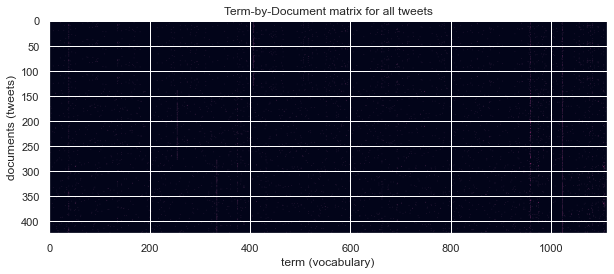

In [206]:
all_termdoc, all_vocab = construct_termdoc(all_tweets_processed)
print('Last 5 vocab words for all tweets:', ' '.join(all_vocab[-5:]))
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(all_termdoc)
ax.set_xlabel('term (vocabulary)')
ax.set_ylabel('documents (tweets)')
ax.set_title('Term-by-Document matrix for all tweets')

**Instruction 2.19**. Next, your task is to write codes in the cell below to calculate the pairwise distance matrix for all tweets collected. Store this distance matrix in the variable named ***all_euclidean_distances*** and visualise this matrix.

[**Total mark: 1**]

Text(0.5, 1.0, 'All Cosine Distances')

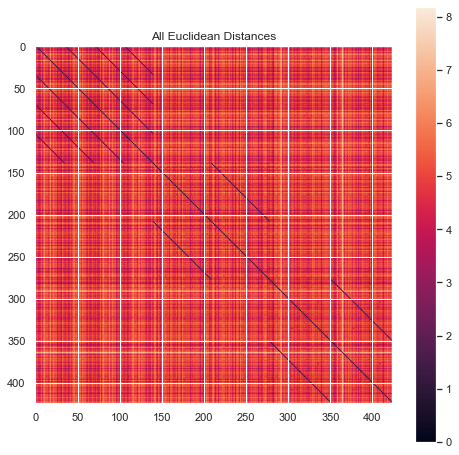

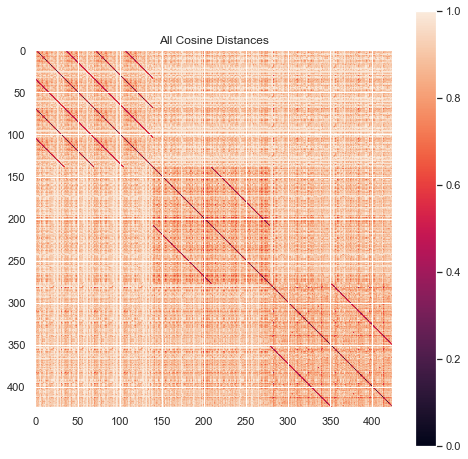

In [207]:
# YOU ARE REQUIRED TO INSERT YOUR CODE IN THIS CELL
all_euclidean_distances, all_cosine_distances = compute_distance_matrices(all_termdoc)

# Visualise the distance matrix for this keyword
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(all_euclidean_distances)
cbar = fig.colorbar(cax)
ax.set_title('All Euclidean Distances')

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(all_cosine_distances)
cbar = fig.colorbar(cax)
ax.set_title('All Cosine Distances')

**Instruction 2.20 (HD)**. 
1. Your task is to produce a scatter plot of Euclidean vs cosine distance for all tweets. [**1 mark**]
2. Fit first and second order polynomials to the data in the scatter plot and overplot them. [**2 marks**]
3. Explain why the plotted curves do not go through the centre of the points cloud. Which visualisation technique would be better to use here? [**1 mark**]

[**Total mark: 4**]

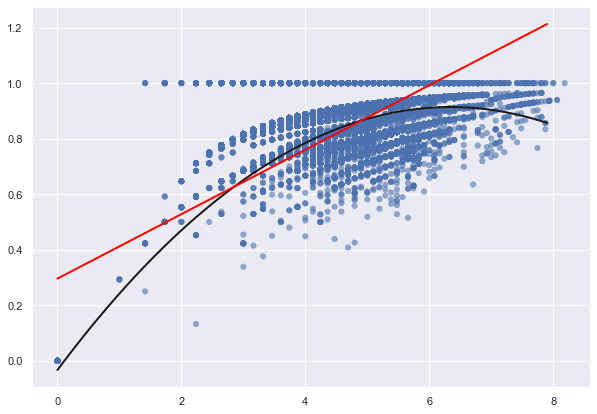

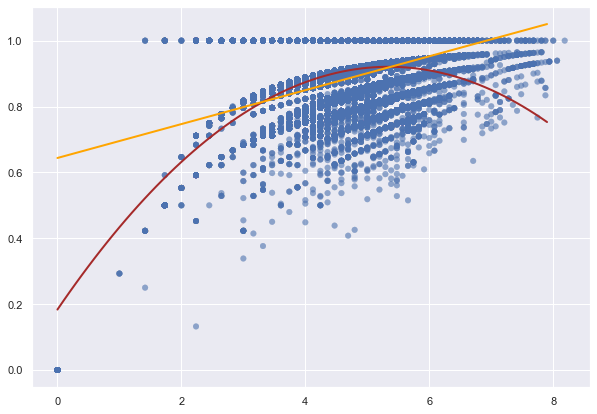

In [233]:
# YOU ARE REQUIRED TO INSERT YOUR CODE IN THIS CELL
# 1. Your task is to produce a scatter plot of Euclidean vs cosine distance for all tweets.
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(all_euclidean_distances, all_cosine_distances, c='b', alpha=0.1, edgecolor='none')

# 2. Fit first and second order polynomials to the data in the scatter plot and overplot it. 
line_coef = np.polyfit(all_euclidean_distances[0], all_cosine_distances[0], 2)
line_xx = np.arange(0, 8, 0.1)
line_yy = line_coef[0]*line_xx*line_xx + line_coef[1]*line_xx + line_coef[2]

ax.plot(line_xx, line_yy, 'k', lw=2)
line_coef = np.polyfit(all_euclidean_distances[0], all_cosine_distances[0], 1)
line_xx = np.arange(0, 8, 0.1)
line_yy = line_coef[0]*line_xx + line_coef[1]
ax.plot(line_xx, line_yy, 'red', lw=2)

# FLATTENED DISTANCE LISTS VERSION
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(all_euclidean_distances, all_cosine_distances, c='b', alpha=0.1, edgecolor='none')

# 2. Fit first and second order polynomials to the data in the scatter plot and overplot it. 
line_coef = np.polyfit(all_euclidean_distances.flatten(), all_cosine_distances.flatten(), 2)
line_xx = np.arange(0, 8, 0.1)
line_yy = line_coef[0]*line_xx*line_xx + line_coef[1]*line_xx + line_coef[2]
ax.plot(line_xx, line_yy, 'brown', lw=2)
line_coef = np.polyfit(all_euclidean_distances.flatten(), all_cosine_distances.flatten(), 1)
line_xx = np.arange(0, 8, 0.1)
line_yy = line_coef[0]*line_xx + line_coef[1]
ax.plot(line_xx, line_yy, 'orange', lw=2)

**Note**. Next, we use Kmeans algorithm to cluster all tweets stored in term-by-document matrix ***all_termdoc***. An important requirement for the Kmeans is the specification of the number of clusters which will be specified the variable **n_clusters**.

The following piece of codes will initialise a ***kmeans*** object to be used for subsequent clustering task.

In [210]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=5, max_iter=3000,
                verbose=True, tol=0.000001, random_state=123456)

**Instruction 2.21**. Your task is to use the variable ***kmeans*** to perform clustering on the data stored in the variable ***all_termdoc***.

[**Total mark: 1**]

In [211]:
kmeans.fit(all_termdoc)
y_kmeans = kmeans.predict(all_termdoc)
print(f'\nTweet Cluster Labels:\n\n{y_kmeans}')

Initialization complete
Iteration 0, inertia 7472.0
Iteration 1, inertia 4983.748565784687
Iteration 2, inertia 4967.914000486976
Iteration 3, inertia 4945.633333333334
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8300.0
Iteration 1, inertia 5024.869665513271
Iteration 2, inertia 4976.305000000001
Iteration 3, inertia 4924.295152354574
Iteration 4, inertia 4912.554594594596
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 6660.0
Iteration 1, inertia 5064.306220095693
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6614.0
Iteration 1, inertia 4984.391920719729
Iteration 2, inertia 4983.277836691415
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7740.0
Iteration 1, inertia 4908.086333210063
Iteration 2, inertia 4897.549262901897
Iteration 3, inertia 4897.006097560979
Converged at iteration 3: strict convergence.

Tw

**Instruction 2.22**. Write your codes to print out the cluster centers.

[**Total mark: 1**]

In [212]:
print(f'Cluster centers:\n\n{kmeans.cluster_centers_}')

Cluster centers:

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.67361738e-18  3.90625000e-02  7.81250000e-03 ...  7.81250000e-03
   7.81250000e-03 -8.67361738e-18]
 [ 1.21951220e-02 -3.46944695e-17  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.21951220e-02]]


**Instruction 2.24 (HD)**. Nevertheless, it is possible to visualise the structure of the cluster centres - surprisingly, using bar charts. Each vector component in the cluster centre vectors corresponds to a word in the dictionary. The value (amplitude) of the vector component for each particular word in the dictionary shows the strength of presence of a word in the cluster.
In this task, you want to:
1. Plot bar charts for each of the three clusters, obtained from KMeans, where each bar chart has 20 strongest words sorted by their presence strength. [**2 marks**]
2. Explain the bar charts from the point of view of chosen keywords, English grammar and our text preprocessing routine. [**1 marks**]

[**Total mark: 3**]

[Text(0, 0, 'the'),
 Text(1, 0, 'url'),
 Text(2, 0, 'and'),
 Text(3, 0, 'design'),
 Text(4, 0, 'expert'),
 Text(5, 0, 'grape'),
 Text(6, 0, 'for'),
 Text(7, 0, 'this'),
 Text(8, 0, 'you'),
 Text(9, 0, 'was'),
 Text(10, 0, 'like'),
 Text(11, 0, 'our'),
 Text(12, 0, 'with'),
 Text(13, 0, 'that'),
 Text(14, 0, 'but'),
 Text(15, 0, 'time'),
 Text(16, 0, 'think'),
 Text(17, 0, 'not'),
 Text(18, 0, 'out'),
 Text(19, 0, 'from')]

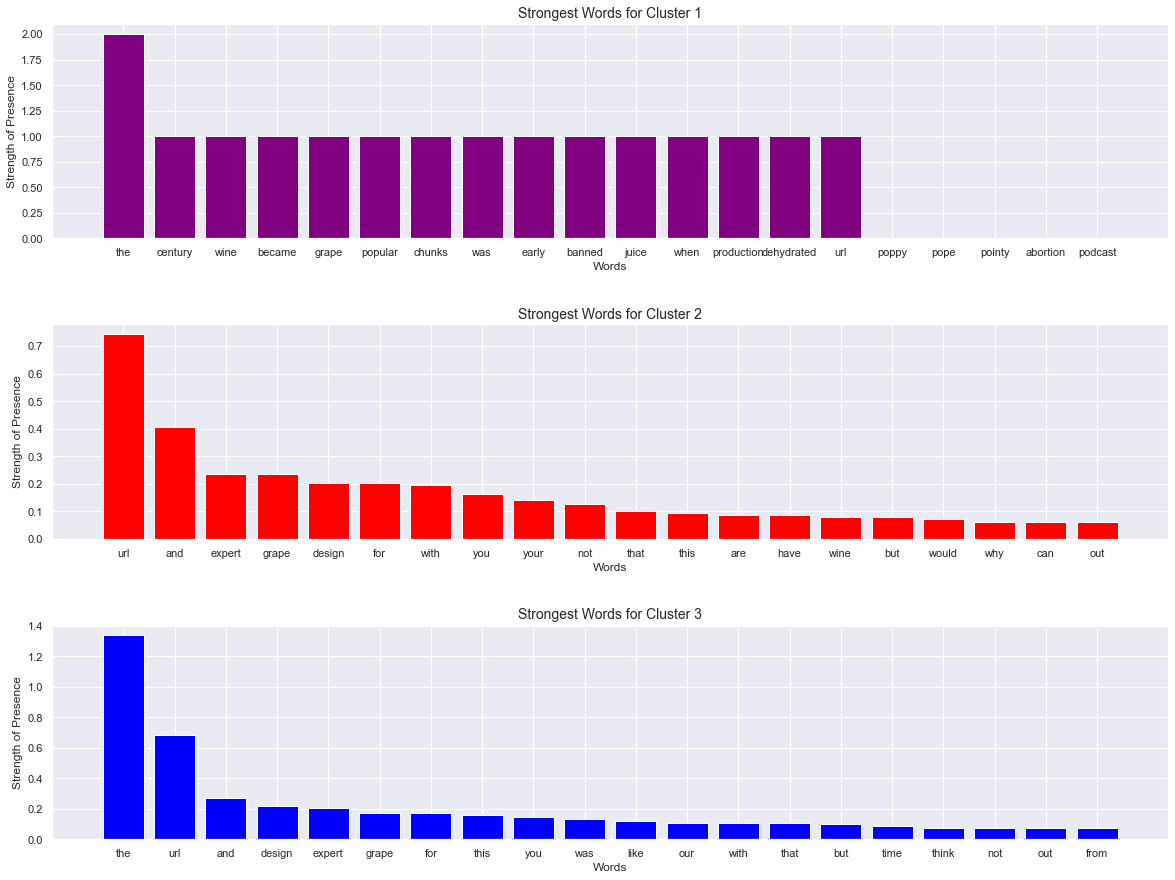

In [214]:
x_pos = np.arange(20)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
fig.subplots_adjust(hspace=0.4)

# Cluster 1
c1_strongest_idx = np.argsort(- kmeans.cluster_centers_[0])
c1_strongest = kmeans.cluster_centers_[0][c1_strongest_idx]
c1_strongest_labels = np.array(all_vocab)[c1_strongest_idx]
ax[0].bar(x_pos, c1_strongest[:20], color='purple', align='center')
ax[0].set_xlabel("Words", fontsize=12)
ax[0].set_ylabel("Strength of Presence", fontsize=12)
ax[0].set_title("Strongest Words for Cluster 1", fontsize=14)

ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(c1_strongest_labels[:20])

# Cluster 2
c2_strongest_idx = np.argsort(- kmeans.cluster_centers_[1])
c2_strongest = kmeans.cluster_centers_[1][c2_strongest_idx]
c2_strongest_labels = np.array(all_vocab)[c2_strongest_idx]
ax[1].bar(x_pos, c2_strongest[:20], color='red', align='center')
ax[1].set_xlabel("Words", fontsize=12)
ax[1].set_ylabel("Strength of Presence", fontsize=12)
ax[1].set_title("Strongest Words for Cluster 2", fontsize=14)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(c2_strongest_labels[:20])

# Cluster 3
c3_strongest_idx = np.argsort(- kmeans.cluster_centers_[2])
c3_strongest = kmeans.cluster_centers_[2][c3_strongest_idx]
c3_strongest_labels = np.array(all_vocab)[c3_strongest_idx]
ax[2].bar(x_pos, c3_strongest[:20], color='blue', align='center')
ax[2].set_xlabel("Words", fontsize=12)
ax[2].set_ylabel("Strength of Presence", fontsize=12)
ax[2].set_title("Strongest Words for Cluster 3", fontsize=14)
ax[2].set_xticks(x_pos)
ax[2].set_xticklabels(c3_strongest_labels[:20])

**Instruction 2.25**. Write your codes to print out the first **200** cluster labels assigned to the first 200 tweets.

[**Total marks: 1**]

In [216]:
print(f'First 200 cluster labels assigned to the first 200 tweets:\n\n{y_kmeans[:200]}')

First 200 cluster labels assigned to the first 200 tweets:

[1 1 2 2 1 2 1 2 1 2 1 1 2 2 0 1 2 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 1 1
 2 2 1 2 1 2 1 2 1 1 2 2 0 1 2 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 1 1 2 2
 1 2 1 2 1 2 1 1 2 2 0 1 2 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 1 1 2 2 1 2
 1 2 1 2 1 1 2 2 0 1 2 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 2 2 1 1 1 1 2 2
 1 1 1 2 1 2 2 2 1 2 1 1 2 2 1 2 1 2 2 1 1 2 2 1 2 1 1 1 1 1 1 2 2 1 2 2 1
 1 2 1 2 1 1 2 2 1 1 1 1 2 1 2]


**Instruction 2.26**. Next, we would like to obtain the quality of our clustering results. Write your code to obtain the labels of tweets for each keyword and store the labels in three new variables ***k1_labels***, ***k2_labels*** and ***k3_labels***, respectively.

**[Total marks: 2]**

In [217]:
k1_labels = y_kmeans[:len(k1_tweets_processed)]
k2_labels = y_kmeans[len(k1_tweets_processed):len(k1_tweets_processed)+len(k2_tweets_processed)]
k3_labels = y_kmeans[len(k1_tweets_processed)+len(k2_tweets_processed):]

**Instruction 2.27 (D)**. We examine what is the proprotion of tweets from different keywords (or categories) appear in the **first** cluster. Remember that **0** is the label for the first cluster (**1** for the second and **2** for the third clusters). Your tasks are:

1. Write your code to obtain the list of tweet indices of each keyword that are assigned to the first cluster. **(1 marks)**

2. Plot a bar chart to visualise the number of tweets of each keyword that are assigned to the first cluster. **(1 marks)**

**[Total mark: 2]**

In [218]:
k1_idx_label0 = [i for i, val in enumerate((k1_labels == 0)) if val]
k2_idx_label0 = [i for i, val in enumerate((k2_labels == 0)) if val]
k3_idx_label0 = [i for i, val in enumerate((k3_labels == 0)) if val]

[Text(0.0, 0, 'grape'), Text(1.0, 0, 'design'), Text(2.0, 0, 'expert')]

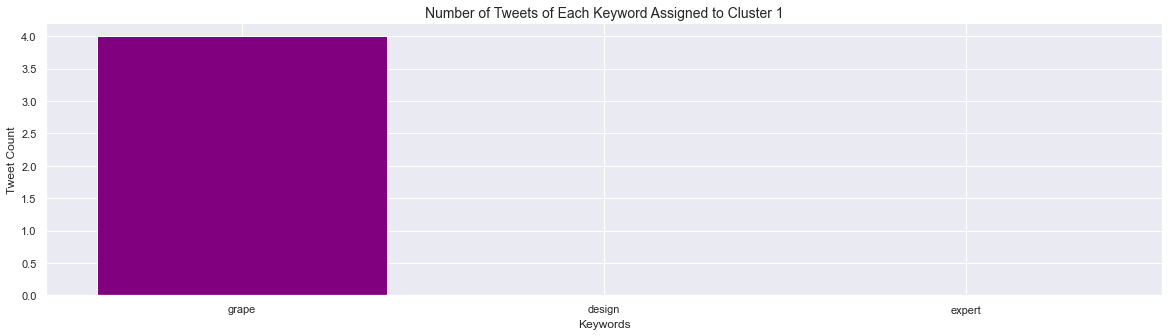

In [219]:
num_tweets0 = [len(k1_idx_label0), len(k2_idx_label0), len(k3_idx_label0)]
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(keywords, num_tweets0, color='purple', align='center')
ax.set_xlabel("Keywords", fontsize=12)
ax.set_ylabel("Tweet Count", fontsize=12)
ax.set_title("Number of Tweets of Each Keyword Assigned to Cluster 1", fontsize=14)
ax.set_xticks(keywords)
ax.set_xticklabels(keywords)

**Instruction 2.28 (D)**. Similarly, write your codes to compute the the proprotion of tweets from different keywords (or categories) appear in the **second** cluster and plot a bar chart visualise this information.

[**Total mark: 1**]

[Text(0.0, 0, 'grape'), Text(1.0, 0, 'design'), Text(2.0, 0, 'expert')]

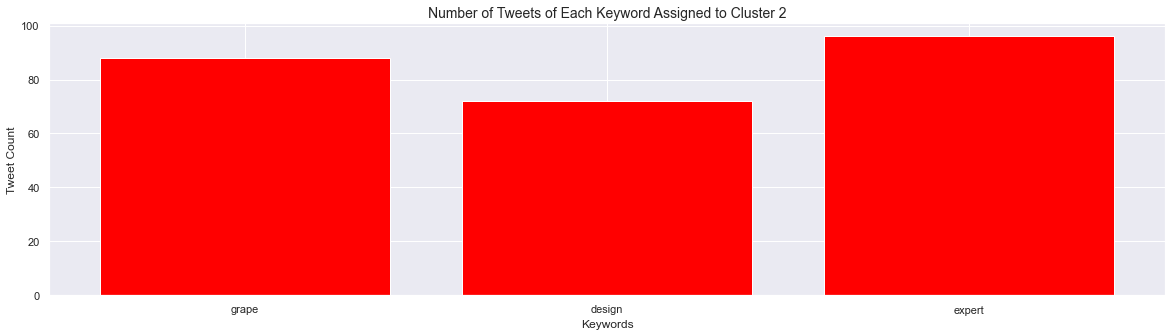

In [220]:
k1_idx_label1 = [i for i, val in enumerate((k1_labels == 1)) if val]
k2_idx_label1 = [i for i, val in enumerate((k2_labels == 1)) if val]
k3_idx_label1 = [i for i, val in enumerate((k3_labels == 1)) if val]
num_tweets1 = [len(k1_idx_label1), len(k2_idx_label1), len(k3_idx_label1)]

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(keywords, num_tweets1, color='red', align='center')

ax.set_xlabel("Keywords", fontsize=12)
ax.set_ylabel("Tweet Count", fontsize=12)
ax.set_title("Number of Tweets of Each Keyword Assigned to Cluster 2", fontsize=14)

ax.set_xticks(keywords)
ax.set_xticklabels(keywords)

### END OF ASSIGNMENT 2 NOTEBOOK

----